In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.max_columns = 100

ref = pd.read_csv('/kaggle/input/flight-delays/airports.csv')

df = pd.read_csv('/kaggle/input/flight-delays/flights.csv'
    , dtype={'ORIGIN_AIRPORT': 'object'
             , 'DESTINATION_AIRPORT': 'object'
             , 'SCHEDULED_DEPARTURE': 'object'
             , 'SCHEDULED_ARRIVAL': 'object'
             , 'DEPARTURE_TIME': 'object'
             , 'ARRIVAL_TIME': 'object'
             , 'SCHEDULED_TIME': 'object'
             , 'ELAPSED_TIME': 'object'
             , 'AIR_TIME': 'object'
             , 'WHEELS_OFF': 'object'
             , 'WHEELS_ON': 'object'
             , 'TAXI_IN': 'object'
             , 'TAXI_OUT': 'object'})

df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.loc[~df['origin_airport'].isin(ref['IATA_CODE'].to_list())]

def convert_time(col):
    return pd.to_datetime(col, format='%H%M', errors='coerce').dt.time

tim = ['scheduled_departure', 'departure_time', 'taxi_out',
       'wheels_off', 'scheduled_time', 'elapsed_time', 'air_time',
       'wheels_on', 'taxi_in', 'scheduled_arrival', 'arrival_time']

for tt in tim:
    df[tt] = convert_time(df[tt])

tim.append('date')
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float')]
cat = [x for x in df.columns if df.dtypes[x] == 'object' and x not in tim]
target = 'departure_delay'
num.remove(target)

# Summary Notes
## Iteraion 01
My plan is to start looking at 1 airline to understand the data and find any anomalies. I choose to start with UA airline because it is in the middle of volume and seems to be consistent throughout the year.

There origin airport around October are not iata codes. They are random numbers which looks like placeholder for missing data. It is a pain. I think I should just focus on the first 3 months of the year as training data and use the 4th month as test data.

## Iteration 00
Merger of American Airlines and US Airways Merger happend around June.


# Explore

In [97]:
samp = df.query('airline == "US"')

<Axes: >

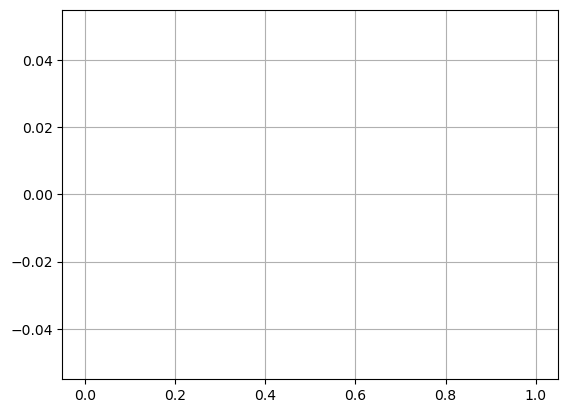

In [98]:
samp['departure_delay'].hist(bins=100)

In [99]:
df.date.describe(datetime_is_numeric=True)

count                           486165
mean     2015-10-15 21:04:58.498658048
min                2015-10-01 00:00:00
25%                2015-10-08 00:00:00
50%                2015-10-16 00:00:00
75%                2015-10-23 00:00:00
max                2015-10-31 00:00:00
Name: date, dtype: object

## Flights by Airlines
Listed all the flights just to check the integrity of the data and saw some that US airline had only half a year worth of data.

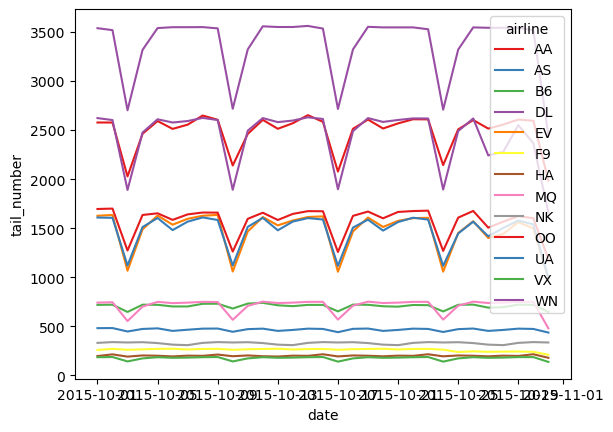

In [100]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## American Airlines and US Airways Merger
It turns out that in 2015, US Airways was acquired by American Airlines.

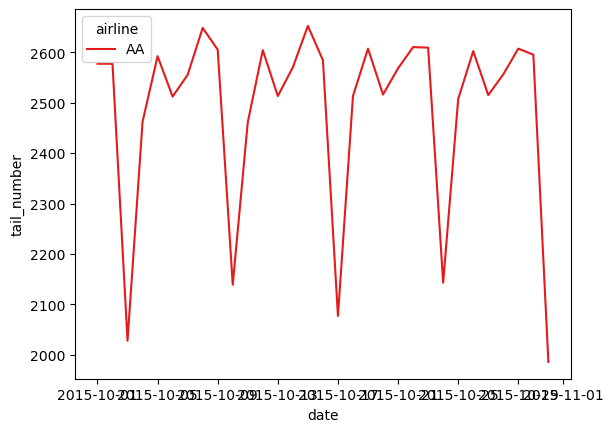

In [101]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g.query('airline==["US", "AA"]')
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## Finding an Airline to start with
The above is interesting but I need to find an airline to work my magic and apply it to the rest to see the bigger picture. "UA" seems to be consistent throughout the year and I will start with that.

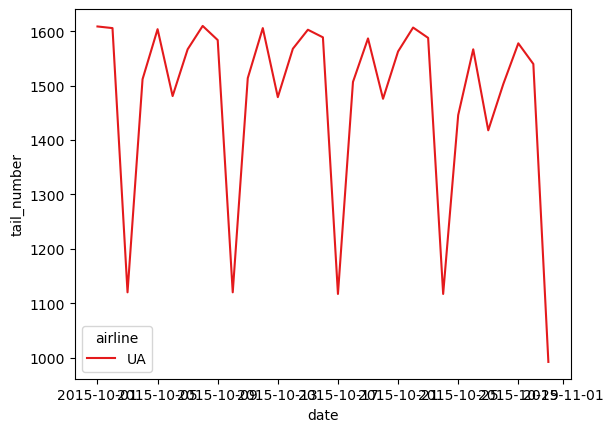

In [102]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g.query('airline==["UA"]')
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

In [103]:
samp = df.query('airline==["UA"]').copy()

In [104]:
samp

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
4385717,2015,10,1,4,UA,684,N495UA,14771,13930,00:14:00,00:13:00,-1.0,01:02:00,00:25:00,NaT,22:09:00,21:02:00,1846,05:57:00,NaT,06:35:00,06:02:00,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385718,2015,10,1,4,UA,1171,N68452,12892,13930,00:14:00,00:11:00,-3.0,02:05:00,00:36:00,02:53:00,02:43:00,20:05:00,1744,06:01:00,01:03:00,06:27:00,06:14:00,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385725,2015,10,1,4,UA,1861,N76529,12889,12266,00:41:00,00:35:00,-6.0,01:01:00,00:46:00,16:07:00,15:07:00,13:07:00,1222,05:03:00,NaT,05:28:00,05:12:00,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385727,2015,10,1,4,UA,1200,N77865,14771,12266,00:45:00,00:35:00,-10.0,01:08:00,00:53:00,21:05:00,21:00:00,18:01:00,1635,05:54:00,01:01:00,06:20:00,06:05:00,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385736,2015,10,1,4,UA,1614,N68880,12892,12266,00:58:00,00:53:00,-5.0,01:01:00,01:04:00,19:02:00,17:08:00,15:08:00,1379,05:42:00,NaT,06:10:00,05:51:00,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871842,2015,10,31,6,UA,1104,N76529,10299,11292,23:49:00,23:41:00,-8.0,02:00:00,00:01:00,03:11:00,NaT,NaT,2405,05:31:00,NaT,06:00:00,05:39:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4871845,2015,10,31,6,UA,706,N826UA,12892,13930,23:50:00,23:42:00,-8.0,01:07:00,23:59:00,02:48:00,22:03:00,20:03:00,1744,04:22:00,NaT,04:58:00,04:25:00,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4871856,2015,10,31,6,UA,1796,N546UA,14771,11618,23:55:00,01:02:00,67.0,01:06:00,01:18:00,03:20:00,03:50:00,03:26:00,2565,08:44:00,NaT,07:15:00,08:52:00,97.0,0,0,NaN,30.0,0.0,67.0,0.0,0.0,2015-10-31
4871875,2015,10,31,6,UA,1696,N68836,14747,12266,23:59:00,23:53:00,-6.0,01:03:00,00:06:00,02:45:00,22:09:00,20:08:00,1874,04:34:00,NaT,05:04:00,04:42:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31


In [105]:
a = samp.groupby(['date', 'origin_airport'])['year'].count()
a.groupby('origin_airport').mean()

origin_airport
10140     3.483871
10257     1.838710
10299     1.838710
10397    12.096774
10423    16.225806
           ...    
15016     1.230769
15024     2.000000
15304    16.548387
15370     1.666667
15376     1.000000
Name: year, Length: 85, dtype: float64

In [106]:
samp['tail_number'].nunique()

628

In [107]:
samp.loc[samp['origin_airport']=='15024']

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
4866782,2015,10,31,6,UA,1445,N14102,15024,12264,13:20:00,13:05:00,-15.0,01:02:00,13:17:00,NaT,02:46:00,22:06:00,1606,17:03:00,NaT,17:40:00,17:11:00,-29.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4867188,2015,10,31,6,UA,1482,N14106,15024,11618,13:50:00,13:33:00,-17.0,01:08:00,13:51:00,NaT,NaT,02:47:00,1634,17:58:00,NaT,18:25:00,18:05:00,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31


In [108]:
samp['origin_airport'].apply(lambda x: x in ref['IATA_CODE'].to_list()).mean()

0.0

In [109]:
samp.loc[~samp['origin_airport'].isin(ref['IATA_CODE'].to_list())]

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
4385717,2015,10,1,4,UA,684,N495UA,14771,13930,00:14:00,00:13:00,-1.0,01:02:00,00:25:00,NaT,22:09:00,21:02:00,1846,05:57:00,NaT,06:35:00,06:02:00,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385718,2015,10,1,4,UA,1171,N68452,12892,13930,00:14:00,00:11:00,-3.0,02:05:00,00:36:00,02:53:00,02:43:00,20:05:00,1744,06:01:00,01:03:00,06:27:00,06:14:00,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385725,2015,10,1,4,UA,1861,N76529,12889,12266,00:41:00,00:35:00,-6.0,01:01:00,00:46:00,16:07:00,15:07:00,13:07:00,1222,05:03:00,NaT,05:28:00,05:12:00,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385727,2015,10,1,4,UA,1200,N77865,14771,12266,00:45:00,00:35:00,-10.0,01:08:00,00:53:00,21:05:00,21:00:00,18:01:00,1635,05:54:00,01:01:00,06:20:00,06:05:00,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385736,2015,10,1,4,UA,1614,N68880,12892,12266,00:58:00,00:53:00,-5.0,01:01:00,01:04:00,19:02:00,17:08:00,15:08:00,1379,05:42:00,NaT,06:10:00,05:51:00,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871842,2015,10,31,6,UA,1104,N76529,10299,11292,23:49:00,23:41:00,-8.0,02:00:00,00:01:00,03:11:00,NaT,NaT,2405,05:31:00,NaT,06:00:00,05:39:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4871845,2015,10,31,6,UA,706,N826UA,12892,13930,23:50:00,23:42:00,-8.0,01:07:00,23:59:00,02:48:00,22:03:00,20:03:00,1744,04:22:00,NaT,04:58:00,04:25:00,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4871856,2015,10,31,6,UA,1796,N546UA,14771,11618,23:55:00,01:02:00,67.0,01:06:00,01:18:00,03:20:00,03:50:00,03:26:00,2565,08:44:00,NaT,07:15:00,08:52:00,97.0,0,0,NaN,30.0,0.0,67.0,0.0,0.0,2015-10-31
4871875,2015,10,31,6,UA,1696,N68836,14747,12266,23:59:00,23:53:00,-6.0,01:03:00,00:06:00,02:45:00,22:09:00,20:08:00,1874,04:34:00,NaT,05:04:00,04:42:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31


In [110]:
samp

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date
4385717,2015,10,1,4,UA,684,N495UA,14771,13930,00:14:00,00:13:00,-1.0,01:02:00,00:25:00,NaT,22:09:00,21:02:00,1846,05:57:00,NaT,06:35:00,06:02:00,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385718,2015,10,1,4,UA,1171,N68452,12892,13930,00:14:00,00:11:00,-3.0,02:05:00,00:36:00,02:53:00,02:43:00,20:05:00,1744,06:01:00,01:03:00,06:27:00,06:14:00,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385725,2015,10,1,4,UA,1861,N76529,12889,12266,00:41:00,00:35:00,-6.0,01:01:00,00:46:00,16:07:00,15:07:00,13:07:00,1222,05:03:00,NaT,05:28:00,05:12:00,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385727,2015,10,1,4,UA,1200,N77865,14771,12266,00:45:00,00:35:00,-10.0,01:08:00,00:53:00,21:05:00,21:00:00,18:01:00,1635,05:54:00,01:01:00,06:20:00,06:05:00,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
4385736,2015,10,1,4,UA,1614,N68880,12892,12266,00:58:00,00:53:00,-5.0,01:01:00,01:04:00,19:02:00,17:08:00,15:08:00,1379,05:42:00,NaT,06:10:00,05:51:00,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871842,2015,10,31,6,UA,1104,N76529,10299,11292,23:49:00,23:41:00,-8.0,02:00:00,00:01:00,03:11:00,NaT,NaT,2405,05:31:00,NaT,06:00:00,05:39:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4871845,2015,10,31,6,UA,706,N826UA,12892,13930,23:50:00,23:42:00,-8.0,01:07:00,23:59:00,02:48:00,22:03:00,20:03:00,1744,04:22:00,NaT,04:58:00,04:25:00,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
4871856,2015,10,31,6,UA,1796,N546UA,14771,11618,23:55:00,01:02:00,67.0,01:06:00,01:18:00,03:20:00,03:50:00,03:26:00,2565,08:44:00,NaT,07:15:00,08:52:00,97.0,0,0,NaN,30.0,0.0,67.0,0.0,0.0,2015-10-31
4871875,2015,10,31,6,UA,1696,N68836,14747,12266,23:59:00,23:53:00,-6.0,01:03:00,00:06:00,02:45:00,22:09:00,20:08:00,1874,04:34:00,NaT,05:04:00,04:42:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-31
